# DenseNet 

마지막

In [1]:
# # 구글 드라이브 연동
# from google.colab import drive
# drive.mount('/content/drive')

# # 폴더 이동
# %cd drive/My\ Drive/ai-school/CXR-pjt
# !pwd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ai-school/CXR-pjt
/content/drive/My Drive/ai-school/CXR-pjt


In [1]:
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet169
from tensorflow.keras.utils import to_categorical
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np 
import glob as gb
import cv2
import os

In [2]:
# 하이퍼파라미터
# epochs = 50

image_size = 224
LABELS = {'PNEUMONIA': 0, 'NORMAL': 1, 'COVID19': 2}

In [5]:
# path 설정 
path_data = "./data_sample"

path_PNEUMONIA = path_data + "/PNEUMONIA"
path_NORMAL = path_data + "/NORMAL"
path_COVID19 = path_data + "/COVID"

In [6]:
len_PNEUMONIA = len(os.listdir(path_PNEUMONIA))
len_NORMAL = len(os.listdir(path_NORMAL))
len_COVID = len(os.listdir(path_COVID19))

print(len_PNEUMONIA)
print(len_NORMAL)
print(len_COVID)

print("total: ", len_COVID + len_NORMAL + len_PNEUMONIA)

1000
1000
1000
total:  3000


In [7]:
# # 이미지 확인
# plt.figure(figsize=(20, 10))
# for i in range(1, 4):
#     plt.subplot(3, 3, i)
#     img = plt.imread(path_NORMAL + f"/NORMAL ({i}).png")
#     plt.imshow(img, cmap='gray')
#     plt.title("NORMAL")


# plt.figure(figsize=(20, 10))
# for i in range(1, 4):
#     plt.subplot(3, 3, i)
#     img = plt.imread(path_COVID19 + f"/COVID-19 ({i}).png")
#     plt.imshow(img, cmap='gray')
#     plt.title("COVID-19")


# plt.figure(figsize=(20, 10))
# for i in range(1, 4):
#     plt.subplot(3, 3, i)
#     img = plt.imread(path_PNEUMONIA + f"/Viral Pneumonia ({i}).png")
#     plt.imshow(img, cmap='gray')
#     plt.title("Viral Pneumonia")

# Data augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 학습 및 검증 데이터용 ImageDataGenerator 생성해 놓기 
train_datagen = ImageDataGenerator(rescale=1./255., 
                                #    horizontal_flip = True, 
                                #    shear_range = 0.2,
                                #    zoom_range = 0.2,
                                #    width_shift_range = 0.2,
                                #    height_shift_range = 0.2,
                                   validation_split = 0.25)

#검증데이터는 정규화 외에 따로 조정 없음 
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.25)

#flow_from_directory()는 앞서 배운 flow()와 비슷, 단 경로를 통채로 가져올 수 있음 
train_generator = train_datagen.flow_from_directory(directory = path_data, #저장 경로 
                                                    subset = 'training',   
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = path_data,
                                                    subset = 'validation',
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [9]:
def getCode(label):
    return LABELS[label]

def getLabel(n):
    for key, val in LABELS.items():
        if n == val:
            return key

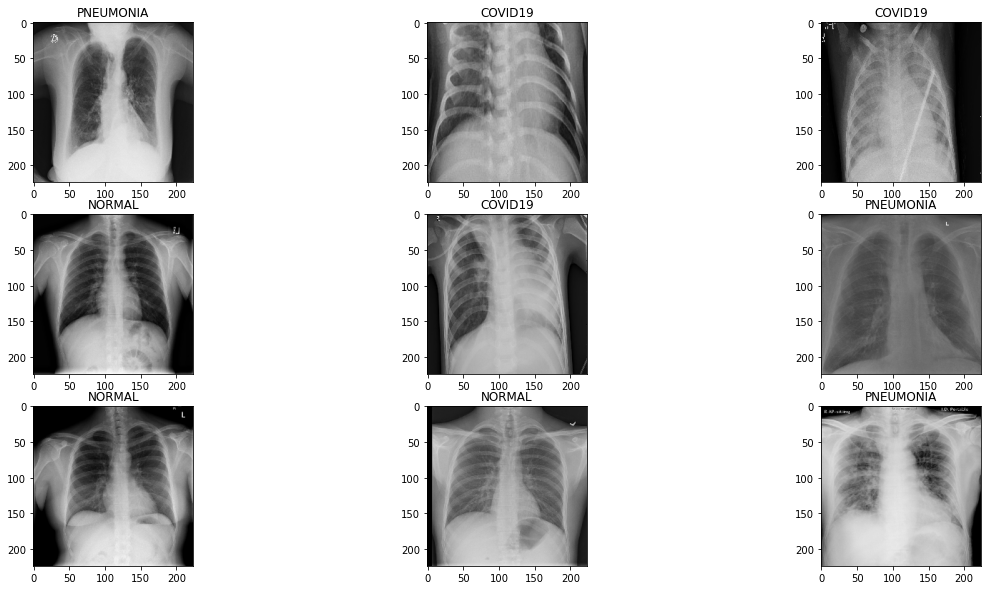

In [11]:
plt.figure(figsize=(20,10))
lst = [100, 200, 300, 400, 550, 600, 700, 900, 1200]
cnt = 1
for i in lst:
    plt.subplot(3, 3, cnt)
    plt.imshow(train_generator.__getitem__(i)[0][0])
    plt.title(getLabel(np.argmax(train_generator.__getitem__(i)[1])) )
    cnt += 1
plt.show()

# DenseNet

In [12]:
densenet = DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)
# densenet = DenseNet169(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

densenet.trainable = False

# for layer in densenet.layers:
#   layer.trainable = False

74842112/74836368 [==============================] - 2s 0us/step


In [13]:
# densenet.summary()

In [14]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = densenet(image_batch)

print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

print(prediction_batch.shape)

(1, 7, 7, 1920)
(1, 1920)
(1, 3)


In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = densenet(inputs, training=False)
x = global_average_layer(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss="categorical_crossentropy", metrics=['accuracy'])

In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 5,763
Non-trainable params: 18,321,984
_________________________________________________________________


In [18]:
len(model.trainable_variables)

2

In [19]:
# initial_epochs = 10
initial_epochs = 2

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=valid_generator)

Epoch 1/2
2250/2250 [==============================] - 487s 216ms/step - loss: 0.5381 - accuracy: 0.8204 - val_loss: 0.3228 - val_accuracy: 0.9080
Epoch 2/2
2250/2250 [==============================] - 495s 220ms/step - loss: 0.2594 - accuracy: 0.9182 - val_loss: 0.2201 - val_accuracy: 0.9360


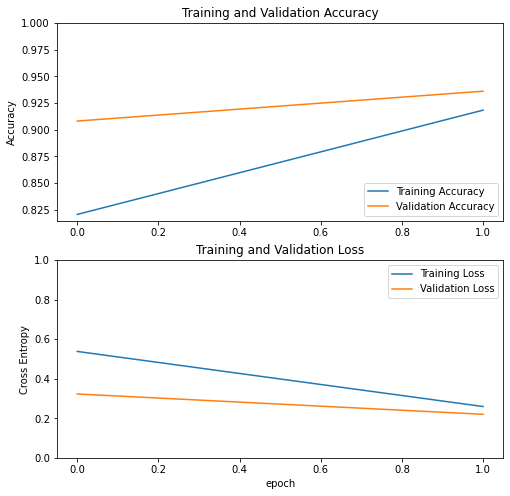

In [20]:
# 학습 곡선
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
model.evaluate(valid_generator)

750/750 [==============================] - 121s 162ms/step - loss: 0.2201 - accuracy: 0.9360


[0.2200973778963089, 0.9359999895095825]

## 미세조정

In [22]:
densenet.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(densenet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in densenet.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  707


In [25]:
# model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10), loss="categorical_crossentropy", metrics=['accuracy'])

In [26]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 15,922,819
Non-trainable params: 2,404,928
_________________________________________________________________


In [27]:
len(model.trainable_variables)

436

In [28]:
# fine_tune_epochs = 10
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_generator)

Epoch 2/4
2250/2250 [==============================] - 975s 433ms/step - loss: 0.1906 - accuracy: 0.9240 - val_loss: 0.1253 - val_accuracy: 0.9573
Epoch 3/4
2250/2250 [==============================] - 1084s 482ms/step - loss: 0.0717 - accuracy: 0.9756 - val_loss: 0.0821 - val_accuracy: 0.9733
Epoch 4/4
2250/2250 [==============================] - 1031s 458ms/step - loss: 0.0673 - accuracy: 0.9769 - val_loss: 0.0609 - val_accuracy: 0.9853


In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

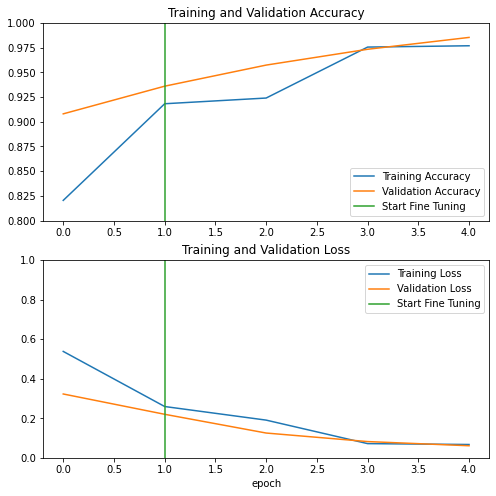

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
model.save('Densenet_model.h5')

In [ ]:
# model.evaluate(test_dataset)

In [ ]:
# epochs = 20
# history = model.fit(train_generator,
#                     epochs=epochs,
#                     validation_data=valid_generator,
#                     callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss')])

Epoch 1/20
15072/15072 [==============================] - 2694s 179ms/step - loss: 0.2001 - accuracy: 0.9312 - val_loss: 0.1060 - val_accuracy: 0.9610
Epoch 2/20
15072/15072 [==============================] - 483s 32ms/step - loss: 0.1428 - accuracy: 0.9539 - val_loss: 0.1276 - val_accuracy: 0.9608
Epoch 3/20
15072/15072 [==============================] - 471s 31ms/step - loss: 0.1230 - accuracy: 0.9596 - val_loss: 0.0567 - val_accuracy: 0.9823
Epoch 4/20
15072/15072 [==============================] - 474s 31ms/step - loss: 0.1116 - accuracy: 0.9626 - val_loss: 0.2344 - val_accuracy: 0.9198
Epoch 5/20
15072/15072 [==============================] - 454s 30ms/step - loss: 0.1030 - accuracy: 0.9668 - val_loss: 0.0661 - val_accuracy: 0.9791
Epoch 6/20
15072/15072 [==============================] - 432s 29ms/step - loss: 0.1019 - accuracy: 0.9677 - val_loss: 0.0854 - val_accuracy: 0.9787


In [ ]:
# 학습된 모델 저장하기
# model.save('densenet_3.h5')

In [32]:
# 예측하기
pred = model.predict(valid_generator)

In [34]:
y_test=[]
for i in tqdm(range(750)):
    y_test.extend(valid_generator.__getitem__(i)[1])

print(len(y_test))
y_test = np.array(y_test)

y_test=np.argmax(y_test, axis=1)
pred= np.argmax(pred, axis=1)

print("pred: ",len(pred))
print("y_test: ",len(y_test))

100%|██████████| 750/750 [00:10<00:00, 71.27it/s]

750
pred:  750
y_test:  750


In [44]:
from sklearn.metrics import confusion_matrix

# cm=confusion_matrix(pred,y_test)

# print(cm)

ImportError: cannot import name 'moduleTNC' from 'scipy.optimize' (C:\Users\Lagom\anaconda3\envs\study\lib\site-packages\scipy\optimize\__init__.py)

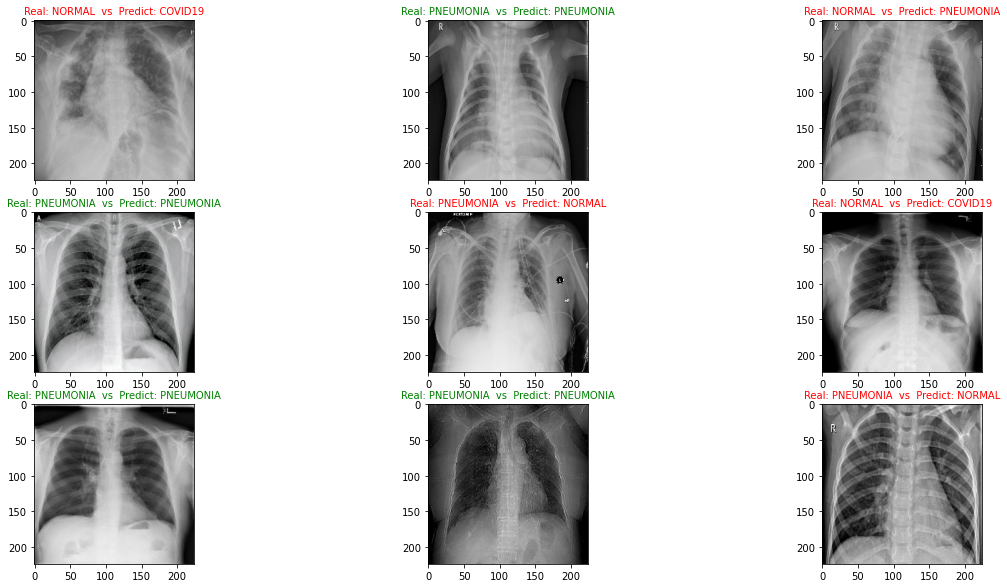

In [39]:
# plt.figure(figsize=(20,10))

# for i in range(9):
#     plt.subplot(3, 3, i+1)
#     plt.imshow(valid_generator.__getitem__(i)[0][0], cmap='gray')
#     color = "green" if y_test[i] == pred[i] else "red"
#     plt.title(f"Real: {getLabel(y_test[i])   }  vs  Predict: {getLabel(pred[i])}", color=color, fontsize=10)
# plt.show()


plt.figure(figsize=(20,10))
lst = [100, 200, 300, 400, 550, 600, 700, 710, 720]
cnt = 1
for i in lst:
    plt.subplot(3, 3, cnt)
    plt.imshow(train_generator.__getitem__(i)[0][0])
    color = "green" if y_test[i] == pred[i] else "red"
    plt.title(f"Real: {getLabel(y_test[i])   }  vs  Predict: {getLabel(pred[i])}", color=color, fontsize=10)
    cnt += 1
plt.show()

In [40]:
model.evaluate(valid_generator)

750/750 [==============================] - 154s 205ms/step - loss: 0.0609 - accuracy: 0.9853


[0.06093452125787735, 0.9853333234786987]

In [41]:
# 예측 함수
def diseasePredict(file_path, ml):
    LABELS = {'PNEUMONIA': 0, 'NORMAL': 1, 'COVID19': 2}

    image = cv2.imread(file_path)
    # image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
    image = cv2.resize(image, dsize=(224, 224))
    image = image / 255.

    reshaped_image = np.expand_dims(image, axis=0)

    pred = ml.predict(reshaped_image)
    pred_code= np.argmax(pred,axis=1)

    disease = getLabel(pred_code)

    return disease


# 예측 이미지 그리기
def showImage(file_path, ml):
    image = cv2.imread(file_path)
    image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)

    plt.imshow(image, cmap='gray')

    disease = diseasePredict(file_path, ml)
    plt.title(disease)
    plt.show()

PNEUMONIA


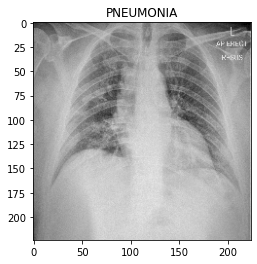

In [43]:
path = "COVID-img.jpg"
# ml = tf.keras.models.load_model('densenet_3.h5')
ml = model

print(diseasePredict(path, ml))

showImage(path, ml)

In [ ]:
# model.save('densenet_333.h5')

# Grad CAM

In [ ]:
# import tensorflow as tf
# import tensorflow.keras.backend as K
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
# import numpy as np
# import os
# import imutils
# import matplotlib.pyplot as plt
# import cv2

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2


class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
def find_target_layer(self):
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
# resize the heatmap to oringnal X-Ray image size
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
# normalize the heatmap
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        
# return the resulting heatmap to the calling function
        return heatmap

In [ ]:
filename = ‘C:\Users\Lagom\lagom\CXR_AI\2. ML\data_sample\COVID’
orignal = cv2.imread(filename)
plt.imshow(orignal)
plt.show()